# 5: Working with StatPoints

Capitalizing on the tree structure of the database can allow you to work more efficiently with large volumes of time series data. This tutorial describes the structure of the database and how it can be used to develop efficient code.

This notebook gives a primer on how the database is structured, and how you can interact with it efficiently.

In [1]:
import btrdb

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from btrdb.utils import timez

In [2]:
# Make sure you add your API key to the config file to connect!
conn = btrdb.connect()

## Database structure
Data are archived using a tree-based structure, where each level of the tree spans a prescribed time interval. The root node spans about 146 years (or $2^{62}$ nanoseconds). At each level of the database, the parent node is time-partitioned into 64 child nodes, each of which spans a time interval $1/64^{th}$ of the parent node. 

Each node is characterized by a parameter called the `pointwidth` which describes how many nanoseconds the node spans. The point width is specified in powers of two, and increases by a factor of 64 (or $2^6$) at each level.

In [3]:
streams = conn.streams_in_collection('sunshine')
stream = streams[2]

print(stream.collection, stream.name, stream.unit)

sunshine/PMU1 C3MAG amps


In [4]:
earliest, _ = stream.earliest()
start = earliest.time

latest, _ = stream.latest()
end = latest.time

In [5]:
# converts from nanoseconds to days
ns_to_days = lambda ns: ns/1e9/60/60/24
ns_to_days(end-start)

561.3946218171296

## Making queries using `aligned_windows`

The `aligned_windows` function rounds the start and end times to the nearest time window native to the database. The query returns a list of `StatPoint` objects, each of which spans $2^{pw}$ nanoseconds (where `pw` is the user-defined pointwidth. Using a larger `pointwidth` returns fewer `StatPoint` that span relatively longer time intervals.

In [6]:
pw = 50 # or 2^50 nanoseconds

t0 = datetime.now()
points = stream.aligned_windows(start=start, end=end, pointwidth=pw)

ns = points[1][0].time - points[0][0].time

print('Stream duration is %.0f days'%(ns_to_days(end-start)))
print('There are %i statpoints in measurement interval, where each statpoint spans %.2f days'%(len(points), ns_to_days(ns)))
print('Query took %.2f seconds to run'%((datetime.now()-t0)).total_seconds())


Stream duration is 561 days
There are 41 statpoints in measurement interval, where each statpoint spans 13.03 days
Query took 0.01 seconds to run


Decreasing the pointwidth returns a longer list with more `StatPoint` objects, each of which spans a shorter time interval. The smaller the `pointwidth`, the longer the query will take to run.

In [7]:
pw = 44 # or 2^38 nanoseconds

t0 = datetime.now()
points = stream.aligned_windows(start=start, end=end, pointwidth=pw)
ns = points[1][0].time - points[0][0].time

print('Stream duration is %.0f days'%(ns_to_days(end-start)))
print('There are %i statpoints, each of which spans %.2f minutes'%(len(points), 24*60*ns_to_days(ns)))
print('Query took %.2f seconds to run'%((datetime.now()-t0)).total_seconds())


Stream duration is 561 days
There are 2444 statpoints, each of which spans 293.20 minutes
Query took 0.06 seconds to run


Each `aligned_windows` query returns a list of tuples giving `(StatPoint, version)`. The following line of code separates these into two lists. Here, we don't care about the versions so we'll store those in a throw-away variable called `_`

In [8]:
statpoints, _ = zip(*points)

## Using StatPoints
Every node in a window is characterized by a `StatPoint` which reports summary statistics including the `mean`, `min`, `max`, `stddev`, and `count` of raw values within the interval. Each `StatPoint` also has a `time`, which describes the start of the interval. Each interval spans the time `(start_time, start_time + ns]`, where `ns=2^{pointwidth}`. Time intervals are inclusive of the `start_time`, and exclusive of `end_time`.

In [9]:
import pandas as pd

def stats_to_df(statpoints, 
                attrs=['count','min','mean','max','stddev','time'],
                pw=44,
                add_start_time=True, 
                add_end_time=True,
               ):
    
    df = pd.DataFrame(columns=attrs, index=range(len(statpoints)))
    for i, spoint in enumerate(statpoints):
        df.loc[i] = [getattr(spoint, attr) for attr in attrs]
    
    if add_start_time:
        df['Interval Start'] = [timez.ns_to_datetime(t) for t in df['time'].tolist()]
        
    if add_end_time:
        df['Interval End'] = [timez.ns_to_datetime(t + 2**pw) for t in df['time'].tolist()]
    return df

df = stats_to_df(statpoints, pw=pw)
print('Table of Summary Statistics')
df.head()

Table of Summary Statistics


,count,min,mean,max,stddev,time,Interval Start,Interval End
0,535165,0.055121,0.174375,0.224571,0.028975,1443702747734999040,2015-10-01 12:32:27.734999+00:00,2015-10-01 17:25:39.921043+00:00
1,2075595,0.085291,0.240711,0.268793,0.022665,1443720339921043456,2015-10-01 17:25:39.921043+00:00,2015-10-01 22:18:52.107088+00:00
2,2111063,0.000149,0.062999,0.199236,0.067157,1443737932107087872,2015-10-01 22:18:52.107088+00:00,2015-10-02 03:12:04.293132+00:00
3,2111062,0.001072,0.00338,0.006424,0.000884,1443755524293132288,2015-10-02 03:12:04.293132+00:00,2015-10-02 08:05:16.479177+00:00
4,2111062,0.001199,0.002734,0.005129,0.000487,1443773116479176704,2015-10-02 08:05:16.479177+00:00,2015-10-02 12:58:28.665221+00:00


We can use the summary statistics to look for time intervals that we want to study in more detail.

## Using StatPoints to detect gaps
Because we know the frequency of the streams (120Hz in the case of our test data), we can use the stat points to find gaps in our streams.


In [10]:
# expected number of points
expected_points = 120 # samples per second
expected_points = 120 * 2**pw / 1e9 # samples per StatPoint

print(expected_points)

2111062.32532992


### Plot the actual vs expected count in each time interval 
By plotting the number of points per stat window vs. the number of points we would exspect based on the frequency and the span of the window, we can find windows with low point counts.

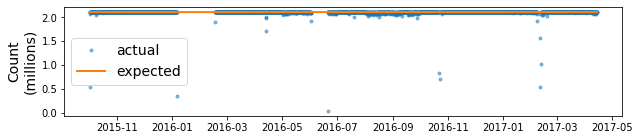

In [11]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(df['Interval Start'], df['count']/1e6, label='actual', ls=' ', marker='.', alpha=0.5)
ax.plot(df['Interval Start'], [expected_points/1e6 for e in df['count']], label='expected', lw=2)
ax.set_ylabel('Count\n(millions)', fontsize=14)
ax.legend(fontsize=14)
plt.show()

### Flag time intervals where there are gaps
We can use this comparison to flag regions with inssuficient points for further investigation.

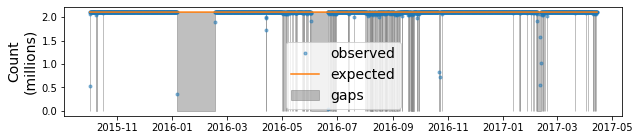

In [12]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(df['Interval Start'], df['count']/1e6, label='observed', ls=' ', marker='.', alpha=0.5)
ax.plot(df['Interval Start'], [expected_points/1e6 for e in df['count']], label='expected')

upper = [expected_points/1e6 for e in df['count']]
lower = [0 for e in df['count']]
ax.fill_between(df['Interval Start'], upper, lower, 
                where=df['count'] < expected_points-10, color='0.5', alpha=0.5,
               label='gaps')

ax.set_ylabel('Count\n(millions)', fontsize=14)
ax.legend(fontsize=14)
plt.show()